# Phân tích chất lượng kết nối mạng bằng thống kê 

Nhà có vài cái máy tính, kết nối qua wifi, nhưng các kết nối đều có vẻ rất không ổn định. Nếu không đo đếm, sẽ rất khó nói cho thuyết phục mà chỉ thuộc team chém gió. Vậy thì đo!

Cách đo đơn giản nhất là dùng lệnh `ping`, gửi ICMP ECHO request đến vài máy trong và ngoài mạng để phân tích. 

# ping - lệnh cơ bản của hệ thống mạng

Trên mọi hệ điều hành hiện đại đều có lệnh ping, kể cả Windows
dù đó là hệ điều hành không thích dùng lệnh cho lắm.

Ping gửi 1 ICMP echo packet (gói tin) đến máy đích và
chờ nó phản hồi.
Chi tiết cách hoạt động của lệnh ping có thể xem tại đây [ping](http://www.familug.org/2014/06/network-ping-pong.html). 

Còn bài này ta sẽ đo kết quả của lệnh ping tới các máy.

## Gần nhất - router

Mọi thiết bị đi đâu thì cũng phải qua router - một thiết bị mạng mà nhiều khi tích hợp sẵn cả cục và gọi là Modem. 
Địa chỉ của cục này thường rất dễ suy đoán, nếu IP máy mình là 192.168.1.127 thì cái cục router khả năng cao là 192.168.1.1.
Nếu mình là 192.168.0.5 thì cục router sẽ có vẻ là 192.168.0.1.

Làm cách có học hơn thì dùng lệnh `ip route` trên Linux:

```sh
$ ip route
default via 192.168.1.100 dev wlan0  proto static  metric 600 
```

Vậy cục này ở 192.168.1.100. Giờ thì ping

In [4]:
! ping 192.168.1.100 -c 1

PING 192.168.1.100 (192.168.1.100) 56(84) bytes of data.
64 bytes from 192.168.1.100: icmp_seq=1 ttl=64 time=2.15 ms

--- 192.168.1.100 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 2.155/2.155/2.155/0.000 ms


Thời gian từ lúc gửi đến lúc nhận 1 packet (Round trip time - RTT) của lệnh ping tới router là 2.15 ms - rất nhanh.

Nhưng về mặt thống kê học, nếu chỉ thử 1 cái, ta chưa thể
đưa ra kết luận được. Vậy nên ta thử trên 100 mẫu:

In [6]:
import subprocess as spr

In [8]:
results = []
router = '192.168.1.100'
for i in range(100):
    try:
        results.append(spr.check_output(['ping', '-c1', router]))
    except spr.CalledProcessError:
        results.append(False)

In [9]:
results.count(False)

5

Có 5 câu lệnh không thành công. Ta kiểm tra số còn lại:

In [10]:
successes = [r for r in results if r]

In [11]:
len(successes)

95

In [12]:
first = successes[0]

In [13]:
first

b'PING 192.168.1.100 (192.168.1.100) 56(84) bytes of data.\n64 bytes from 192.168.1.100: icmp_seq=1 ttl=64 time=13.4 ms\n\n--- 192.168.1.100 ping statistics ---\n1 packets transmitted, 1 received, 0% packet loss, time 0ms\nrtt min/avg/max/mdev = 13.480/13.480/13.480/0.000 ms\n'

In [20]:
float(first.decode('utf-8').split()[-2].split('/')[0])

13.48

kết quả của các câu lệnh là dạng byte, ta cần convert thành string bằng `decode('utf-8')`, sau đó chia ra các phần phân bởi dấu space và xuống dòng, lấy giá trị rtt min (round trip time - ở đây lấy min max gì cũng được vì ta chỉ ping 1 phát).

In [21]:
rtts = [float(r.decode('utf-8').split()[-2].split('/')[0]) for r 
       in successes]

In [22]:
rtts[:10]

[13.48, 3.352, 3.64, 4.279, 1.496, 1.526, 1.228, 2.47, 3.188, 2.744]

In [23]:
import pandas as pd

In [24]:
%matplotlib inline

In [25]:
rtt_series = pd.Series(rtts)

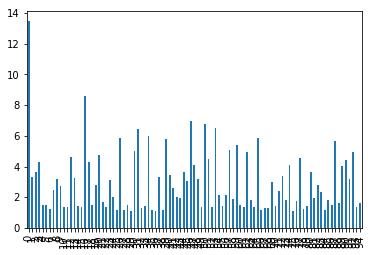

In [26]:
rtt_series.plot.bar()

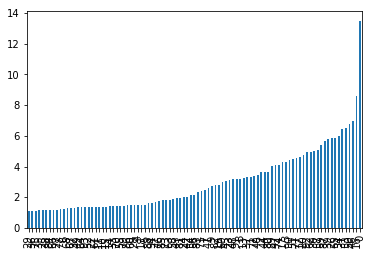

In [28]:
rtt_series.sort_values().plot.bar()

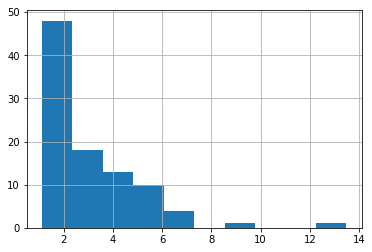

In [29]:
rtt_series.hist()

Biểu đồ trên cho thấy hơn 50 % kết quả là < 3ms. Chưa rõ là tốt hay không. Ta cần thử với các thiết bị khác trọng mạng. Nhưng đây sẽ là kết quả tốt nhất ta có, vì đây là router.

In [76]:
def do_n_ping_and_plot_histogram(host, n=100):
    results = []
    for i in range(n):
        try:
            results.append(spr.check_output(['ping', '-c1', host]))
        except spr.CalledProcessError:
            results.append(False)
    
    print('Failed {} times'.format(results.count(False)))
    successes = [r for r in results if r]
    rtts = [float(r.decode('utf-8').split()[-2].split('/')[0]) for r 
            in successes]
    rtt_series = pd.Series(rtts)
    print(rtt_series.describe())
    rtt_series.hist()
    return rtt_series

Failed 12 times
count    88.000000
mean      5.895670
std       5.394742
min       2.082000
25%       2.606500
50%       4.586000
75%       6.620750
max      36.089000
dtype: float64


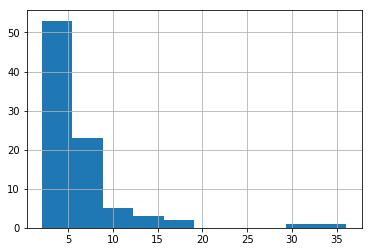

In [38]:
rtts = do_n_ping_and_plot_histogram('192.168.1.131')

Có tới 12 packet fail và số còn lại hầu hết đều < 6ms.

Lệnh ping có cung cấp các số liệu thống kê mô tả:
    
```
$ ping 192.168.1.100 -c3
PING 192.168.1.100 (192.168.1.100) 56(84) bytes of data.
64 bytes from 192.168.1.100: icmp_seq=1 ttl=64 time=147 ms
64 bytes from 192.168.1.100: icmp_seq=2 ttl=64 time=3.09 ms
64 bytes from 192.168.1.100: icmp_seq=3 ttl=64 time=7.38 ms

--- 192.168.1.100 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2002ms
rtt min/avg/max/mdev = 3.092/52.635/147.433/67.055 ms
```

Nhưng các số liệu thống kê mô tả (describe statistics) như min, average, max, moving deviation không thể nào so sánh với đồ thị histogram của ta. 

# Thử với 1 host ở xa, vd 8.8.8.8 - DNS của Google,  1.1.1.1 DNS của cloudflare, 203.162.4.191 DNS của VNPT

Failed 17 times
count     83.000000
mean      40.226771
std       39.253032
min       28.429000
25%       29.149000
50%       30.121000
75%       33.955000
max      344.391000
dtype: float64
Failed 18 times
count     82.000000
mean      46.180524
std       63.609518
min       30.765000
25%       32.052000
50%       34.411000
75%       39.951750
max      584.523000
dtype: float64
Failed 24 times
count     76.000000
mean      16.718882
std       43.635468
min        2.570000
25%        3.180750
50%        5.287000
75%        9.860500
max      337.613000
dtype: float64


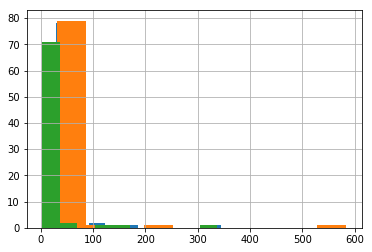

In [39]:
data = []
for ip in '8.8.8.8', '1.1.1.1', '203.162.4.191':
    data.append(do_n_ping_and_plot_histogram(ip, n=100))

In [46]:
min([len(r) for r in data])

76

In [53]:
data[0][0]

29.690999999999999

In [47]:
equal_data = [r[:76] for r in data]

In [49]:
import numpy as np

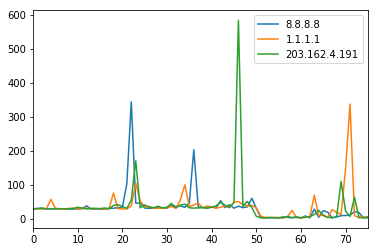

In [59]:
df = pd.DataFrame(columns=['8.8.8.8', '1.1.1.1', '203.162.4.191'],
             data=np.array(equal_data).reshape((-1, 3)))
df.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6a4149588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa6a6d964e0>]], dtype=object)

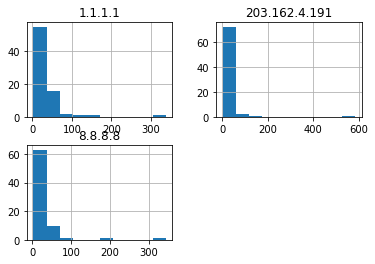

In [69]:
df.hist()

In [ ]:
import matplotlib.pyplot as plt

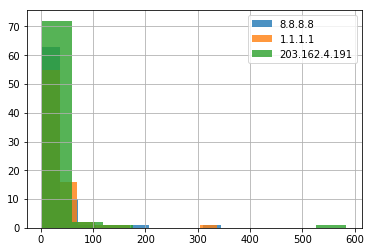

In [74]:
for col in df.columns:
    df[col].hist(alpha=0.8, label=col)
plt.legend(loc='upper right')

PS: đoạn code trên có thể thay bằng
```python
df.plot(kind='hist', alpha=80)
```

Với phiên bản pandas mới nhất tại thời điểm viết: pandas==0.20.2

Có thể thấy ping các nhà cung cấp DNS quốc tế, RTT ~ 40 ms, VNPT cho kết quả tốt hơn hẳn với giá trị trung bình cỡ 16 ms - không có gì đáng ngạc nhiên hay khen ngơi, vì mạng mình đang dùng là của:

In [75]:
import requests
print(requests.get('https://ipinfo.io').text)

{
  "ip": "27.77.251.201",
  "hostname": "localhost",
  "city": "Ho Chi Minh City",
  "region": "Ho Chi Minh City",
  "country": "VN",
  "loc": "10.8142,106.6440",
  "org": "AS7552 Viettel Group"
}


ISP là Viettel.

- Chuyện mạng trong nước nhanh hơn mạng nước ngoài không có gì phải bàn cả.
- 1.1.1.1 trong bài test này chậm hơn so với 8.8.8.8 cỡ ~ 10ms
- Chất lượng mạng/wifi khá tồi khi tỷ lệ packet fail là ~ 20% ra internet và ~ 10% trong mạng LAN.

# Cải tiến
- Ở đây ta thực hiện 100 cú ping lần lượt, họat động này có thể thực hiện song song bằng cách dùng thread hay async, thế nhưng ping 100 lần tới cùng 1 thiết bị rồi đo sẽ không đảm bảo do đường truyền và đích đều hoạt động khác đi so với khi ping lần lượt. 

Hết.

HVN at https://pymi.vn and http://www.familug.org

In [79]:
import datetime; print(datetime.datetime.now())

2018-04-21 17:38:07.035475
